# COMP0142

# Assignment 2: Classification with Naive Bayes & Logistic Regression

## Introduction

In this assignment, we will implement multiclass classification using Logistic Regression and Naive Bayes via the Scikit-learn library.

In Part A of this assignment, we are going to implement Logistic Regression. First, we are going to examine how data scaling affects the performance of the classifier: We will produce a classification report and plot a confusion matrix. We are then going to use cross validation to more reliably compare the performance of the models.

In Part B of this assignment, we are going to implement multiclass and Bernoulli Naive Bayes. We are going to perform feature selection and analyse the performance of the model. Finally, we are also going to look at decision boundaries.

We are going to work with two datasets:
- The 'Gene expression cancer RNA-Seq' dataset 
- The 'Zoo' dataset.

## Guidelines

- The structure of the code is given to you and you will need to fill in the parts corresponding to each question. 
- You will have to submit the completed notebook in the Jupyter notebook format: `.ipynb`.
- Do not modify/erase other parts of the code if you have not been given specific instructions to do so.
- When you are asked to insert code, do so between the areas which begin:
  
  `##########################################################`
  
  `# TO_DO`
  
  `#[your code here]`
   
   And which end:
   
  `# /TO_DO
   ##########################################################`


- When you are asked to comment on the results you should give clear and comprehensible explanations. Write the comments in a 'Code Cell' with a sign `#` at the beginning of each row, and in the areas which begin:

  `# [INSERT YOUR ANSWER HERE]`

## Imports

Please do not change the cell below, you will see a number of imports. All these packages are relevant for the assignment and it is important that you get used to them. You can find more information about them in their respective documentation. The most relevant package for this assignment is Scikit-learn:

https://scikit-learn.org/stable/

In [2]:
#PLEASE DO NOT CHANGE THIS CELL

# Standard python libraries for data and visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
import seaborn as sns

# SciKit Learn python ML Library
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB

# Import error metric
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Import library for handling warnings
import warnings

In [3]:
#PLEASE DO NOT CHANGE THIS CELL

# Functions to use
# Decision boundary plotting 
def plot_predictions(X, y, clf):
    h = .02  # step size in the mesh
 
    # create a mesh to plot in
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.figure(figsize=(8,6))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    pylab.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel(list(X.head(0))[0])
    plt.ylabel(list(X.head(0))[1])
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(np.arange(min(X.iloc[:, 0]), max(X.iloc[:, 0])+1, 1.0))
    plt.yticks(np.arange(min(X.iloc[:, 1]), max(X.iloc[:, 1])+1, 1.0))
    plt.title(clf)

    plt.show
    
# confusion matrix plotting plotting
def plot_conf_matrix(conf_matrix):
    plt.figure(figsize=(5,5))
    sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu" ,fmt='g')    
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');

# Part A: Logistic Regression [50 marks]

## Seeds dataset
This dataset contains gene expression data from patients diagnosed with one of tumor types: BRCA, KIRC, COAD, LUAD and PRAD. Each feature corresponds to a different gene. 

Dataset location: https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq

Number of instances: 801

Number of features: 20531   

All of these parameters are real-valued continuous. To reduce computation time, we are going to work with the first 200 features.

## Load dataset
Please save the 'data.csv' and 'labels.csv' files included in the assignement zip file, which contain this data, and change the paths below to the paths leading to the location of your downloaded files. You may want to use os.chdir to change directory. 

In [4]:
# PLEASE CHANGE THE FILE PATHS 

file_path_data = "./OpenBookTest2_Q1_Data.csv"
file_path_labels = "./labels.csv"

TypeError: '(slice(None, None, None), 0)' is an invalid key

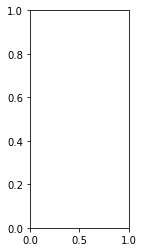

In [17]:
#PLEASE DO NOT CHANGE THIS CELL

# read the file with pandas.read_csv
X = pd.read_csv(file_path_data, usecols=[*range(1, 3)])
y = pd.read_csv(file_path_data, usecols=[2]).values.ravel()

def plot_results(X, y, method, model, idx_plot):
    plt.subplot(1, 3, idx_plot)

    X0, X1 = X[y == 0], X[y == 1]  # data corresponding to classes 0 and 1

    plt.scatter(X0[:, 0], X0[:, 1], color='green')  # class 0
    plt.scatter(X1[:, 0], X1[:, 1], color='blue')  # class 1

    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.contour(xx, yy, Z, [0.5], colors='black')
    
    plt.title(method)

nb = BernoulliNB()
nb.fit(X,y)
plot_results(X, y, 'LDA', nb, 2)


plt.show()

## Data analysis and pre-processing 
Below, we will generate histograms of the first 12 'Gene expression cancer RNA-Seq' dataset features.

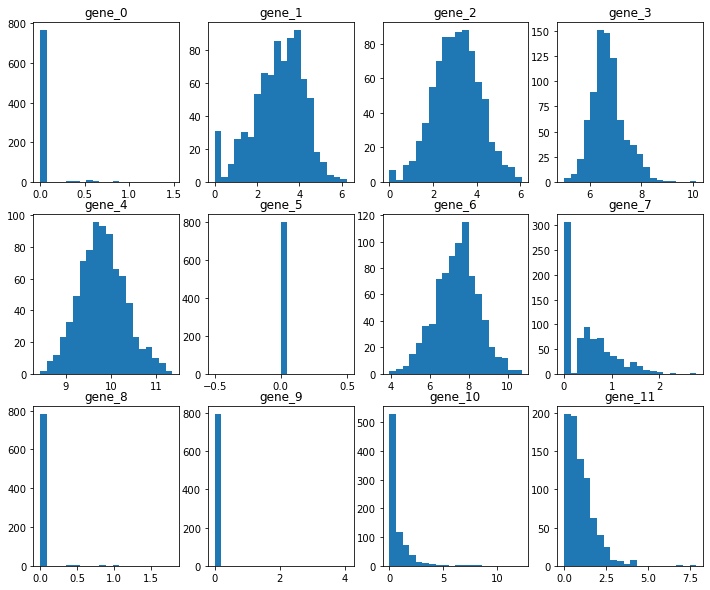

In [46]:
#PLEASE DO NOT CHANGE THIS CELL

figs, axs = plt.subplots(3, 4, figsize=(12, 10))
axs = axs.ravel()

for counter in range(12):
    col = X.columns[counter]
    axs[counter].hist(X[col], bins=20)
    axs[counter].set_title(col)

Regularisation makes the classifier dependent on the scale of the features. 

We are going to scale the features and compare the performance of Logistic Regression on unscaled and scaled dataset. 

### _Question 1 [10 marks]_ 

### _a) [3 marks]_ 
- Use `StandardScaler()` to scale the data. Save the result to a new variable (do not overwrite X).

In [47]:
#######################################################
# TO_DO
#[your code here]

scaler = StandardScaler()
X_scale = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

#/TO_DO
#######################################################

### _b) [3 marks]_
-  Explain how the `StandardScaler()` function changes the data, (in particular its mean and variance)? (**Hint:** You can re-run the code from the section **Data analysis and pre-processing** in order to visualise scaled values.)

In [48]:
# [StandardScaler removes the mean and scales each feature column into unit variance (i.e., it normalises the data) so we can have a common scale in our data.]
    
#

### _c) [4 marks]_
- `LogisticRegression()` uses $\ell_2$ regularisation as default. How does the effect of data scaling relate to the assumptions made by regularisation?

In [49]:
# [# It's because the ridge is a scaled variant. ℓ2  regularisation imposes a penalty on the size of coefficients of the linear regression. Thus, these coefficients will shrink towards zero, but if these coefficients are not on the same scale, the regularisation is not fair.]

#

### Classifier performance analysis

A Confusion Matrix is a table used for the evaluation of classification models. The x axis represents predicted labels while the y axis represents actual labels. Each cell indicates the sum of instances assigned to a particular combination of these labels. Diagonal values represents correctly classified instances.  

### _Question 2 [20 marks]_

### _a) [5 marks]_ 
- Create training and testing datasets for the unscaled and scaled data.

In [50]:
lg = LogisticRegression(solver = "lbfgs", multi_class = "multinomial", max_iter = 5000)
lg_scaled = LogisticRegression(solver = "lbfgs", multi_class = "multinomial", max_iter = 5000)

#######################################################
# TO_DO
#[your code here]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)


X_sc_train, X_sc_test, y_sc_train, y_sc_test = train_test_split(X_scale, y, test_size=0.2, random_state=18)


#/TO_DO
#######################################################

### _b) [5 marks]_ 
- Fit `LogisticRegression()` to the unscaled and scaled data. ***[5 marks]***

In [51]:
#######################################################
# TO_DO
#[your code here]
lg.fit(X_train, y_train)
lg_scaled.fit(X_sc_train, y_sc_train)


#/TO_DO
#######################################################

LogisticRegression(max_iter=5000, multi_class='multinomial')

### _c) [5 marks]_ 
- Print confusion matrices using Scikit-learn `confusion_matrix()` functon defined for you at the beginning of the notebook.

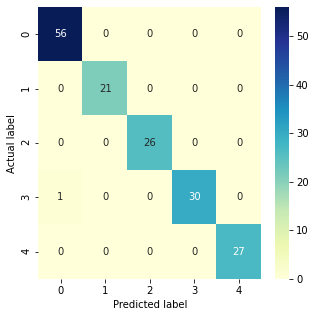

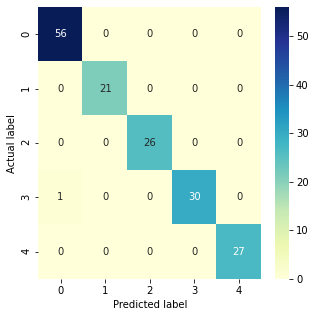

In [52]:
#######################################################
# TO_DO
#[your code here]
   

#lg_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
#lg_scaled.fit(X_sc_train, y_sc_train)

y_sc_pred = lg_scaled.predict(X_sc_test)
y_pred = lg.predict(X_test)

conf_sc_matrix = confusion_matrix(y_sc_test, y_sc_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

plot_conf_matrix(conf_matrix)
plot_conf_matrix(conf_sc_matrix)


#/TO_DO
#######################################################

### _d) [5 marks]_ 
- Print classification report using scikit-learn `classification_report()` function. You can use `target_names = label_list` to include labels.

In [53]:
#######################################################
# TO_DO
#[your code here]

print(classification_report(y_test, y_pred, target_names=label_list))

#/TO_DO
#######################################################

              precision    recall  f1-score   support

        BRCA       0.98      1.00      0.99        56
        KIRC       1.00      1.00      1.00        21
        COAD       1.00      1.00      1.00        26
        LUAD       1.00      0.97      0.98        31
        PRAD       1.00      1.00      1.00        27

    accuracy                           0.99       161
   macro avg       1.00      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



### Cross validation
In Scikit-learn, `StratifiedKFold()` splits the data into $k$ different folds.  
`cross_val_score()` then uses these folds to run the classifier multiple times and collect multiple accuracy scores.   

### _Question 3 [20 marks]_

### _a) [5 marks]_ 
- Split data using `StratifiedKFold()`. Set `n_splits = 10`, `shuffle = True`, and `random_state=42`.

In [54]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # please note the lines above are used to silence sklearn warnings
    # which is not necessary
    
    #######################################################
    # TO_DO
    #[your code here]
skf = StratifiedKFold(n_splits=10,shuffle = True, random_state=42)
skf.get_n_splits(X_sc_train, y_sc_train)

    #/TO_DO
    ########################################################

10

### _b) [5 marks]_ 
- Calculate cross validation scores using `cross_val_score()`. Call the variables storing these scores `lg_scores` and `lg_scaled_scores` (for consistency with plotting done for you in the subsequent section). (**Hint:** `cv` is equal to the output of `StratifiedKFold()`.)

In [55]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # please note the lines above are used to silence sklearn warnings
    # which is not necessary

    #######################################################
    # TO_DO
    #[your code here]
lg_scores = cross_val_score(lg, X, y, cv=10)

lg_scaled_scores = cross_val_score(lg, X_scale, y, cv=10)


    
    #/TO_DO
    ########################################################

### _c) [5 marks]_ 
- Calculate and print the mean of the scores.

In [56]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # please note the lines above are used to silence sklearn warnings
    # which is not necessary

    #######################################################
    # TO_DO
    #[your code here]
lg_scores.mean()
print (lg_scores.mean())

lg_scaled_scores.mean()
print(lg_scaled_scores.mean())


    
    #/TO_DO
    ########################################################

0.9950154320987654
0.99375


### _d) [5 marks]_ 
- Unlike vanilla `KFold()`, `StratifiedKFold()` aims to preserve the proportion of examples belonging to each class in each split. Does `StratifiedKFold()` make each data split balanced if the whole dataset is not balanced?

In [57]:
# [# Yes. KFold() randomly divides the sample data into k sets and use a single subset as the validation data for the remaining k-1 sets of sample data. So the proportion of example might not be balanced. However, StratifiedKFold() splits the data so that the mean response value is approximately equal in all sets. So it will make each data split balanced even if the whole dataset is not balanced.]

#

We can visualise the scores using a box plot. It highlights the lower and upper quartiles, and "whiskers" showing the extent of the scores.  

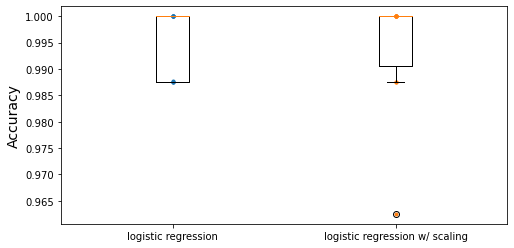

In [58]:
#PLEASE DO NOT CHANGE THIS CELL

plt.figure(figsize=(8, 4))
plt.plot([1]*10, lg_scores, ".")
plt.plot([2]*10, lg_scaled_scores, ".")
plt.boxplot([lg_scores, lg_scaled_scores], labels=("logistic regression","logistic regression w/ scaling"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

# Part B: Naive Bayes [50 marks]

Please note that we are still working with the 'Gene expression cancer RNA-Seq' dataset loaded in Part A.  

### Removing correlated features
Feature independence is an assumption of Naive Bayes. Naive Bayes is particularly sensitive to feature correlations which can lead to overfitting. Based on data alone, we cannot test if features are truly independent, but we can exclude correlated features.
Below, we test if features are correlated.

### _Question 4 [10 marks]_
Drop features with correlation above 0.75. 

**Hint:** see what `to_drop` returns, then use it as an argument in the *pandas* `drop()` function with `axis = 1`.

In [59]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

#######################################################
# TO_DO
#[your code here]


df = pd.DataFrame(X)
X_new = df.drop(to_drop, axis=1)



#/TO_DO
#######################################################

print("Correlated features dropped: ")
print(*to_drop, sep = ", ") 

Correlated features dropped: 
gene_72, gene_92, gene_93, gene_95, gene_145, gene_180, gene_188


### Recursive feature elimination
Lets go further and select the 5 most important features. Recursive Feature Elimination (RFE) is designed to select features by recursively considering smaller and smaller sets of features.  

### _Question 5 [10 marks]_

### _a) [5 marks]_ 
- Use the `RFE()` function in Scikit-learn to select features. (**Hint:** Check the Scikit-learn documentation and example.)

### _b) [5 marks]_ 
- After selecting features to eliminate, use the `support_` attribute as a mask to select the right columns.

              precision    recall  f1-score   support

        BRCA       0.73      0.62      0.67        56
        KIRC       0.64      0.67      0.65        21
        COAD       0.69      0.96      0.81        26
        LUAD       0.67      0.26      0.37        31
        PRAD       0.56      0.89      0.69        27

    accuracy                           0.66       161
   macro avg       0.66      0.68      0.64       161
weighted avg       0.67      0.66      0.64       161



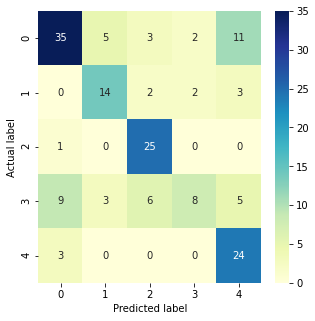

In [60]:
nb = MultinomialNB()

#######################################################
# TO_DO
#[your code here]

estimator = nb
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_new, y)
selector.support_


X.drop(X_new.columns[np.where(selector.support_ == False)[0]], axis=1, inplace=True)

#/TO_DO
#######################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)
nb.fit(X_train, y_train)
nb_predict = nb.predict(X_test)
print(classification_report(y_test, nb_predict, target_names = label_list))
nb_confusion = confusion_matrix(y_test, nb_predict)
plot_conf_matrix(nb_confusion)

We are now going to switch to a different dataset.
### Zoo dataset 
This is a simple dataset which classifies animals into 7 categories. 

Dataset location: https://archive.ics.uci.edu/ml/datasets/Zoo  

Number of instances: 210

Number of features: 17

Attribute Information:  
1. animal name: Unique for each instance   
2. hair:	Boolean   
3. feathers:	Boolean   
4. eggs:	Boolean   
5. milk:	Boolean   
6. airborne:	Boolean   
7. aquatic:	Boolean   
8. predator:	Boolean   
9. toothed:	Boolean   
10. backbone:	Boolean   
11. breathes:	Boolean   
12. venomous:	Boolean   
13. fins:	Boolean   
14. legs:	Numeric (set of values: {0,2,4,5,6,8})   
15. tail:	Boolean   
16. domestic:	Boolean   
17. catsize:	Boolean   
18. type:	Numeric (integer values in range [1,7])  

All of these parameters are discrete-valued.
  
### Load dataset
Please save the 'zoo.csv' file included in the assignement zip file, which contains a subset of this data, and change the paths below to the paths leading  to the location of your downloaded files. You may want to use `os.chdir` to change directory.

In [61]:
# PLEASE CHANGE THE FILE PATHS 

file_path_data_zoo = "./zoo.csv"

In [62]:
#PLEASE DO NOT CHANGE THIS CELL

# read the file with pandas.read_csv
data_zoo = pd.read_csv(file_path_data_zoo)

# because the file does not contain header information, we manually add headers of the dataset
data_zoo.columns = ["animal name", "hair", "feathers","eggs", 
                "milk", "airborne","aquatic", "predator", "toothed", "backbone", 
                    "breathless", "venomous", "fins", "legs", "tail", "domestic", "catsize", "class"]

We assign columns 2 to 18 (everything other than animal name and class) to variable `X_zoo`. Remember that indexing starts at 0.  
We assign the "class" column to variable `y`.  
We then split `X` and `y` into train and test datasets.

In [63]:
#PLEASE DO NOT CHANGE THIS CELL

X_zoo = data_zoo.iloc[:,1:17]
y_zoo = data_zoo["class"]
X_zoo_train, X_zoo_test, y_zoo_train, y_zoo_test = train_test_split(X_zoo, y_zoo, test_size=0.2, random_state=18)

Below, we create a test dataset which contains only animals with 4 or fewer legs. 

In [64]:
#PLEASE DO NOT CHANGE THIS CELL

data_drop = data_zoo.iloc[:,1:18].drop(data_zoo[data_zoo["legs"]>4].index).sample(frac=0.8)

X_drop_train = data_drop.iloc[:,0:16]
y_drop_train = data_drop["class"]

We create an instance of a multinomial Naive Bayes classifier. We train `nb` on `X_drop_train`, and test it on `X_zoo_test`.  
You should get an error message suggesting that the value of alpha is automatically overwritten.

In [65]:
#PLEASE DO NOT CHANGE THIS CELL

nb = MultinomialNB(alpha =0)
nb.fit(X_drop_train, y_drop_train)
nb_predict_train = nb.predict(X_drop_train)
nb_predict_test = nb.predict(X_zoo_test)
print(accuracy_score(nb_predict_train, y_drop_train))
print(accuracy_score(nb_predict_test, y_zoo_test))

0.9857142857142858
0.9


/Users/namdamin/opt/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


### _Question 6 [10 marks]_   
Please comment on what the alpha parameter does.
**Hints:**  
- Think what Naive Bayes does when encountering a discrete feature value of which is absent in the train dataset but which is present in the test dataset. What probability estimate would be associated with it?  
- See: Scikit-learn `MultinomialNB` documentation, in particular the description of the alpha parameter https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html  
- Google "additive smoothing".

In [66]:
### [# With discrete featured data, the probability mass function is obtained in a frequentist setting using the Maximum likelihood estimation. MLE encourages us to estimate the probability of zero if we never observe it (i.e., was absent in the training dataset), but this could result in overfitting because the resulting parameter would be zero. This implies that probability for any input attribute conditional on state k would be zero for all k and we get undefined value probability for k conditional on input for all k (0 divided by 0). To solve this problem, we add instances uniformly to the data by adding alpha parameter and we avoid zero divided by zero issues.]

#

We are now going  to repeat the above process using Naive Bayes for features with the Bernoulli distribution (`BernoulliNB()` in scikit-learn). We are particularly interested in interpreting decision boundaries of Bernoulli Naive Bayes.

### _Question 7 [20 marks]_

### _a) [2 marks]_ 
- Use recursive feature elimination (RFE) is to select only 2 features (**Note:** in real life cases, you are likely to use this approach to select multiple rather than just two feature. In this case we are asking you to analyse the outcome, and 2 features allows us to more visualise the decision boundary more easily.)

### _b) [1 mark]_ 
- After selecting the features to eliminate, use support_ attribute as a mask to select the right columns. 

In [67]:
nb = BernoulliNB()

#######################################################
# TO_DO
#[your code here]
#data_zoo.drop (['eggs','hair', 'airborne','aquatic','predator','toothed','backbone','breathless','venomous', 'fins', 'legs','tail', 'domestic', 'catsize','class'], axis =1)
#X_zoo = data_zoo.iloc[:,2:4]
#y_zoo = data_zoo["class"]

estimator = nb
selector = RFE(estimator, n_features_to_select=2)
selector = selector.fit(X_zoo, y_zoo)
selector.support_
X_zoo.drop(X_zoo.columns[np.where(selector.support_ == False)[0]], axis=1, inplace=True)
#data_zoo = pd.DataFrame(selector.fit_transform(X_zoo, y_zoo))
#X_new = pd.DataFrame(selector.fit_transform(X_zoo, y_zoo))
#selector.transform(X_zoo)
#X_zoo = pd.DataFrame(selector.fit_transform(X_zoo, y_zoo))
#/TO_DO
#######################################################

### _c) [2 marks]_ 
- Split data into train and test sets (set `random_state=18`).

### _d) [1 mark]_ 
- Fit the model.

In [68]:
#######################################################
# TO_DO
#[your code here]

X_z_train, X_z_test, y_z_train, y_z_test = train_test_split(X_zoo, y_zoo, test_size=0.2, random_state=18)
#X_zoo_train, X_zoo_test, y_zoo_train, y_zoo_test = train_test_split(X_zoo, y_zoo, test_size=0.2, random_state=18)
nb.fit(X_z_train, y_z_train)
#nb.fit(X_zoo_train, y_zoo_train)

#/TO_DO
##########################################################

BernoulliNB()

### _e) [2 marks]_ 
- Create a Confusion Matrix using the `plot_conf_matrix()`

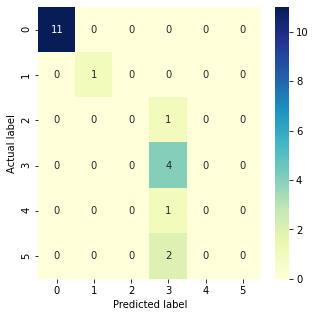

In [69]:
#######################################################
# TO_DO
#[your code here]

nb_zoo_predict = nb.predict(X_z_test)
nb_zoo_confusion = confusion_matrix(y_z_test, nb_zoo_predict)
plot_conf_matrix(nb_zoo_confusion)

#/TO_DO
##########################################################

### _f) [2 marks]_ 
- Plot decision boundaries using the `plot_predictions()` function.

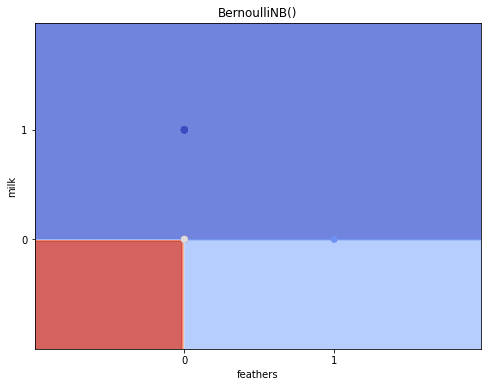

In [70]:
#######################################################
# TO_DO
#[your code here]


plot_predictions(X_z_test, y_z_test, nb)

#/TO_DO
##########################################################

### _g) [10 marks]_ 
- Interpret the decision boundaries: Recall the shapes of decision boundaries you have seen in classes - were they straight and crossing at right angles? Why is this the case when using `BernoulliNB()`?

In [71]:
### [# The shape of decision boundaries depends on the data we have. If the data is not linearly seperable, then the decision boundaries would not be linear, and therefore, not be straight. The decision boundry we have is straight and crossing at right angles because we are using discret features with BernoulliNB() and our data is binary since we selected two most import features, milk and feathers. So we will have a decision boundary that is 1D in a 2D space where the margin, the perpendicular distance between the boundaries and the points, is . It is also straight because the data is linearly seperatable. We could observe the three support vectors in our diagram which determines the weights. Thus, the decsions boundaries implies that there are greater number of animals that produce milks and have feathers in our data than the number of animals that have neither of them.]

#